### Packages

In [1]:
#requirements !pip freeze > requirements.txt.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Load and Organise data

## Import data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort/master/german_credit.csv")
df.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


## Pre-process variables

In [3]:
# variable types
df.dtypes

default                        int64
account_check_status          object
duration_in_month              int64
credit_history                object
purpose                       object
credit_amount                  int64
savings                       object
present_emp_since             object
installment_as_income_perc     int64
personal_status_sex           object
other_debtors                 object
present_res_since              int64
property                      object
age                            int64
other_installment_plans       object
housing                       object
credits_this_bank              int64
job                           object
people_under_maintenance       int64
telephone                     object
foreign_worker                object
dtype: object

In [4]:
# categorical variables
cat_variables = ['account_check_status', 'credit_history', 'purpose', 'savings', 'present_emp_since', 'personal_status_sex',
                'property', 'other_installment_plans', 'housing', 'job', 'telephone', "other_debtors", 'foreign_worker']

# target variable
output_variable = ["default"]

# other integer variables
int_variables = ['credits_this_bank', 'present_res_since', 'duration_in_month', 'people_under_maintenance', 
                 'installment_as_income_perc', 'age', 'credit_amount']
# list(set(df.columns) - set(output_variable) - set(cat_variables))

In [5]:
# pre-allocation
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# quick check
df_cat.mean()

account_check_status_0 <= ... < 200 DM                                        0.269
account_check_status_< 0 DM                                                   0.274
account_check_status_>= 200 DM / salary assignments for at least 1 year       0.063
account_check_status_no checking account                                      0.394
credit_history_all credits at this bank paid back duly                        0.049
credit_history_critical account/ other credits existing (not at this bank)    0.293
credit_history_delay in paying off in the past                                0.088
credit_history_existing credits paid back duly till now                       0.530
credit_history_no credits taken/ all credits paid back duly                   0.040
purpose_(vacation - does not exist?)                                          0.050
purpose_business                                                              0.097
purpose_car (new)                                                           

In [6]:
# bracketing integer variable - age
from sklearn.preprocessing import KBinsDiscretizer
kbin_func = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile').fit(df[["age"]])
df_age = pd.DataFrame(kbin_func.transform(df[["age"]]).toarray(), columns=["young", "adult", "senior"])

# checking
pd.concat([df_age, df[["age"]]], axis=1).head(10)

,young,adult,senior,age
0,0.0,0.0,1.0,67
1,1.0,0.0,0.0,22
2,0.0,0.0,1.0,49
3,0.0,0.0,1.0,45
4,0.0,0.0,1.0,53
5,0.0,1.0,0.0,35
6,0.0,0.0,1.0,53
7,0.0,1.0,0.0,35
8,0.0,0.0,1.0,61
9,0.0,1.0,0.0,28


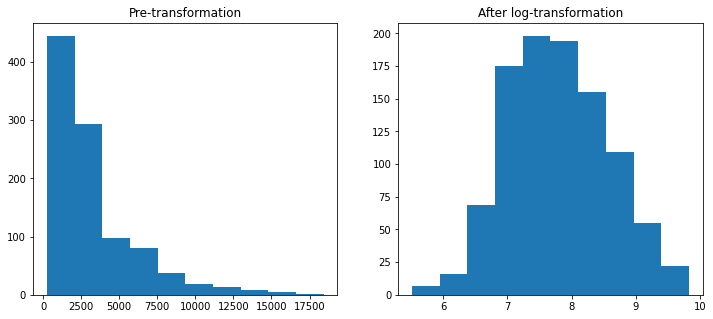

In [7]:
# other types of transformations possible - log transformation 
from sklearn.preprocessing import FunctionTransformer
log_mapping = FunctionTransformer(func=np.log, inverse_func=np.exp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(df["credit_amount"])
ax1.set_title("Pre-transformation")

ax2.hist(log_mapping.transform(df["credit_amount"]))
ax2.set_title("After log-transformation")
df_log = pd.DataFrame(log_mapping.transform(df["credit_amount"]).values, columns=["log(credit)"])

## Consolidating a final dataset

In [8]:
df_model = pd.concat([df[int_variables[:-2]], df_cat, df_age, df_log, df[output_variable]], axis=1)
df.shape, df_model.shape

((1000, 21), (1000, 64))

In [9]:
df_model.head()

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,...,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior,log(credit),default
0,2,4,6,1,4,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.063904,0
1,1,2,48,1,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,8.691315,1
2,1,3,12,2,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.647786,0
3,1,4,42,2,2,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.972337,0
4,2,4,24,2,3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.490849,1


## Visualization: PCA, t-SNE

explained variance ratio (first two components): [0.9316043 0.0091663]


Text(0.5, 1.0, 'PCA of German Credit dataset')

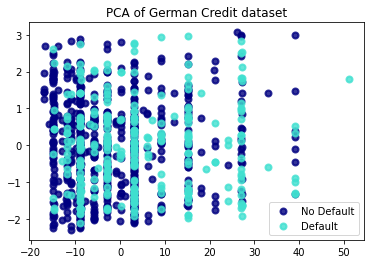

In [10]:
from sklearn.decomposition import PCA
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of German Credit dataset')

Text(0.5, 1.0, 't-SNE of German Credit dataset')

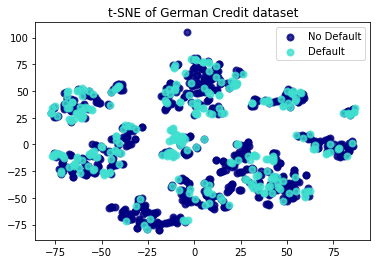

In [11]:
from sklearn.manifold import TSNE
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=5)
X_r = tsne.fit_transform(X)

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE of German Credit dataset')    

# Modelling

## Kernel SVM: Grid-search + Stratified K-fold-CV

In [12]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# params
k_folds = StratifiedKFold(n_splits=3, random_state=10, shuffle=True) # 3-fold -

hyper_params = {"kernel_svc__C": [10.00 ** 2, 10.00 ** 3, 10.00 ** 4], # 5
                "kernel_svc__gamma": (np.array([10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.0 ** 2]) * 1.0/df_model.shape[1]).tolist(),
                # [10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1] * 1.0/df_model.shape[1],
                "kernel_svc__kernel": ["rbf"], # rbf (radial basis function) a.k.a. gaussian kernel
                "kernel_svc__probability": [True]
                }

# = 75 models in total

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss
               }
for pf in perf_metrics:
    perf_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

# main method
# split the data into inputs and output
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values

# instantiate the model - Pipeline where we scale the variables using StandardScaler = (x - mu)/sigma; kernel SVM
model_pipeline = Pipeline([("scaler", StandardScaler()),
                           ("kernel_svc", SVC())]
                         )

# run the grid-search CV procedure
model = GridSearchCV(estimator=model_pipeline, 
                     param_grid=hyper_params, 
                     scoring=perf_metrics, 
                     cv=k_folds, 
                     refit="F1-Score"
                    )
model.fit(X, y.ravel())

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('kernel_svc', SVC())]),
             param_grid={'kernel_svc__C': [100.0, 1000.0, 10000.0],
                         'kernel_svc__gamma': [0.00015625, 0.0015625, 0.015625,
                                               0.15625, 1.5625],
                         'kernel_svc__kernel': ['rbf'],
                         'kernel_svc__probability': [True]},
             refit='F1-Score',
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'Brier': make_scorer(brier_score_loss),
                      'F1-Score': make_scorer(f1_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)})

In [13]:
# - done by GridSearchCV
# for every hyperparameter
## for every (train, test) fold
### model_pipeline.fit(X[train], y[train])
### model_pipelin.predict(X[test], y[test])
### compute performance metrics
### store results

### Show results

In [14]:
# get best model
best_model = model.best_estimator_
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('kernel_svc',
                 SVC(C=100.0, gamma=0.0015625, probability=True))])

In [15]:
# store all results and avg results in a df
df_cv = pd.DataFrame(model.cv_results_)

# add a hyperparameter column in avg df
from sklearn.model_selection import ParameterGrid
df_hyperparams = pd.DataFrame(list(ParameterGrid(model.param_grid)))
df_avgcv = pd.DataFrame(columns=perf_metrics.keys())
for pf in perf_metrics.keys():
    df_avgcv[pf] = df_cv["mean_test_" + pf]
df_avgcv = pd.concat([df_hyperparams, df_avgcv], axis=1)

<AxesSubplot:xlabel='kernel_svc__C', ylabel='F1-Score'>

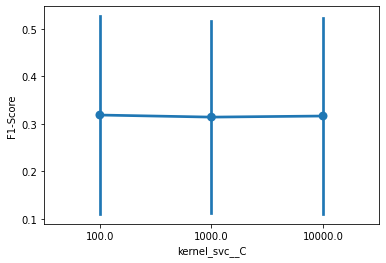

In [16]:
sns.pointplot(x="kernel_svc__C", y="F1-Score", data=df_avgcv)

<AxesSubplot:xlabel='kernel_svc__gamma', ylabel='F1-Score'>

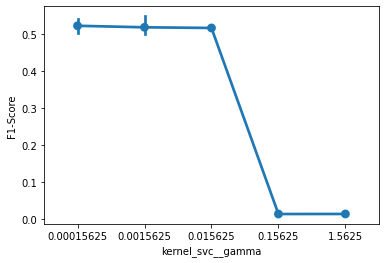

In [17]:
sns.pointplot(x="kernel_svc__gamma", y="F1-Score", data=df_avgcv)

In [18]:
df_avgcv.loc[df_avgcv["F1-Score"].idxmax()]

kernel_svc__C                 100.0
kernel_svc__gamma          0.001563
kernel_svc__kernel              rbf
kernel_svc__probability        True
Accuracy                   0.758004
Precision                   0.61978
Recall                     0.493333
AUC                        0.682368
F1-Score                   0.547698
Brier                      0.241996
Name: 1, dtype: object

### Feature Importance chart

<AxesSubplot:ylabel='Variable'>

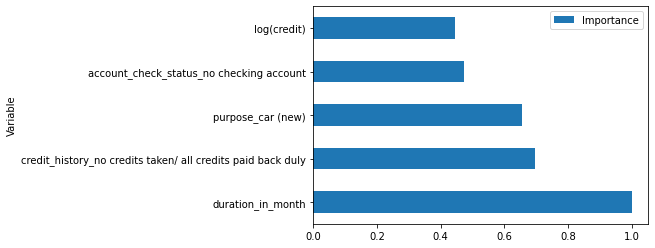

In [19]:
from sklearn.inspection import permutation_importance

feat_imp = permutation_importance(best_model, X, y, n_repeats=5, random_state=10)

df_featimp = pd.DataFrame({"Variable": df_model.drop(output_variable, axis=1).columns,
                           "Importance": feat_imp['importances_mean']/feat_imp["importances_mean"].max()})

df_featimp = df_featimp.sort_values("Importance", ascending=False)

# chart
df_featimp.iloc[:5].plot(x="Variable", y="Importance", kind="barh")

### Partial dependence plot

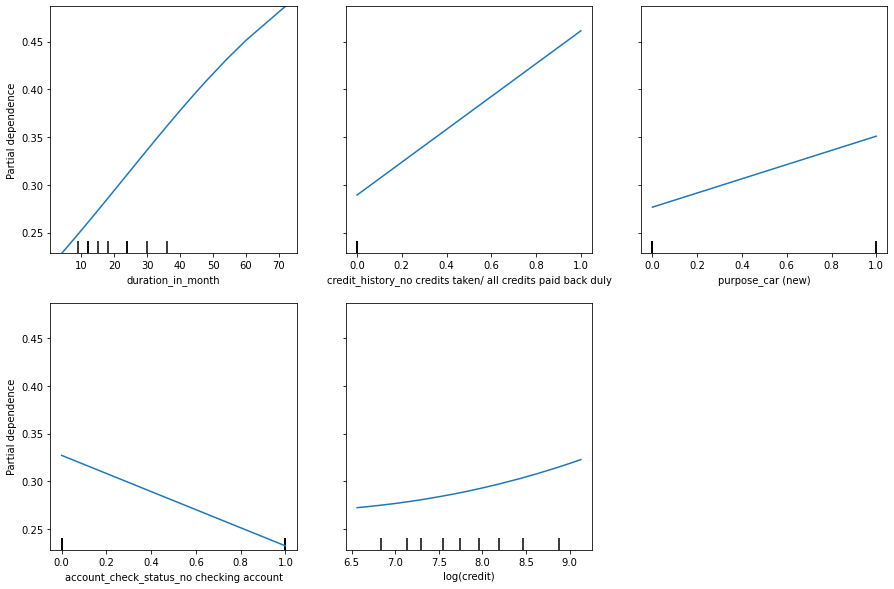

In [20]:
from sklearn.inspection import plot_partial_dependence
z = pd.DataFrame(X, columns=df_model.drop(output_variable, axis=1).columns)
fig, ax = plt.subplots(figsize=(15, 10))
plot_partial_dependence(best_model, z, df_featimp["Variable"].iloc[:5], 
                        ax=ax, response_method="predict_proba", 
                        method="brute", grid_resolution=200
                       ) 

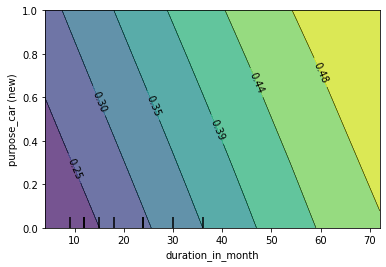

In [21]:
#fig, ax = plt.subplots(figsize=(7, 7))
plot_partial_dependence(best_model, z, [(df_featimp["Variable"].iloc[0], df_featimp["Variable"].iloc[2])], 
                        response_method="predict_proba", method="brute")

Text(0.5, 1.0, 't-SNE of German Credit dataset - Predicted')

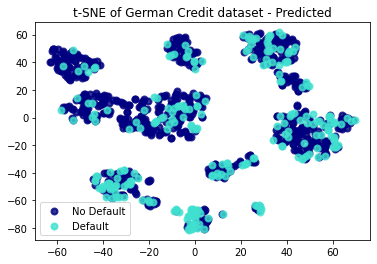

In [22]:
from sklearn.manifold import TSNE
X, y = df_model.drop(labels=output_variable, axis=1).values, best_model.predict(X)
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=10)
X_r = tsne.fit_transform(X)

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE of German Credit dataset - Predicted')    

Text(0.5, 1.0, 't-SNE of German Credit dataset - Observed')

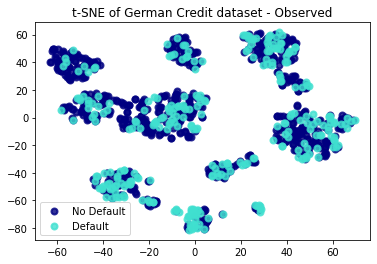

In [23]:
from sklearn.manifold import TSNE
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=10)
X_r = tsne.fit_transform(X)

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE of German Credit dataset - Observed')    

## Reducing optimism bias in hyper-parameter optimization, and comparing strategies: Nested Cross-Validation/Resampling

### Initial Params

In [24]:
def MCC(y_true, y_pred):

    # confusion matrix components
    TP = sum((y_true.ravel()==1) * (y_pred.ravel()==1)) # catch the criminal
    TN = sum((y_true.ravel()==0) * (y_pred.ravel()==0)) # there was no criminal
    FP = sum((y_true.ravel()==0) * (y_pred.ravel()==1)) # false alarm
    FN = sum((y_true.ravel()==1) * (y_pred.ravel()==0)) # broken alarm
    
    # numerator
    Num = (TP * TN - FP * FN)
    
    # denominator
    Den = np.sqrt(TP + FP)*np.sqrt(TP + FN)*np.sqrt(TN + FP)*np.sqrt(TN + FN)
    
    return Num/Den # Num/Den

class KPI:
    def __init__(self, loan):
        self.loan = loan
    
    def KPI(self, y_true, y_pred):
        amount_repaid = (y_true.ravel()==1) * (y_pred.ravel()==1) * self.loan
        amount_loss = (y_true.ravel()==0) * (y_pred.ravel()==1) * self.loan
        return np.sum(amount_repaid - amount_loss)

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# k-fold params
inner_folds = StratifiedKFold(n_splits=3, random_state=10, shuffle=True) # inner k-fold
outer_folds = StratifiedKFold(n_splits=2, random_state=10, shuffle=True) # outer k-fold

# models
model_dict = {"GBT": GradientBoostingClassifier(random_state=10),
              "Tree": DecisionTreeClassifier(random_state=10),
              
              "MLP": Pipeline([("std", StandardScaler()), 
                               ("mlp", MLPClassifier(random_state=10))]),
              
              "KNN": Pipeline([("std", StandardScaler()),
                               ("knn", KNeighborsClassifier())]),
              
              "Logistic": LogisticRegression(penalty="none", solver="lbfgs"),
              "LassoLogistic": Pipeline([("std", StandardScaler()), 
                                         ("lasso", LogisticRegression(penalty="l1", solver='liblinear'))]),
              "ElasticNet": Pipeline([("std", StandardScaler()), 
                                      ("en", LogisticRegression(penalty="elasticnet", solver="saga"))]),
              "UnifRandom": DummyClassifier(strategy="uniform"), 
              "StratRandom": DummyClassifier(strategy="stratified"),
              "SVM": Pipeline([("std", StandardScaler()), 
                               ("svc", SVC(kernel="rbf", probability=True))]),
              #"Naive Bayes": GaussianNB()
             }

# models hyperparams
hyper_params = {"GBT": {"learning_rate": [10.0 ** -1, 10.0 ** 0, 2.0],
                        "max_depth": [1, 2, 3],
                        "max_features": [0.1, 0.25, 0.5],
                        "n_estimators": [200]},
                
                "Tree": {"max_depth": [1, 3, 5, 7, 9],
                         "class_weight": [None, "balanced"]},
                
                "MLP": {"mlp__hidden_layer_sizes": [(5,), (10,), (50,)], 
                        "mlp__activation": ['relu', 'tanh']
                       },
                "KNN": {"knn__n_neighbors": [1, 3, 5, 7]
                       },
                "Logistic": {"class_weight": [None, "balanced"]},
                
                "LassoLogistic": {"lasso__C": [10.0 ** -4, 10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** 0],
                                  "lasso__class_weight": [None, "balanced"]},
                
                "ElasticNet": {"en__C": [10.0 ** -4, 10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** -0],
                               "en__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
                               "en__class_weight": [None, "balanced"]},
                
                "UnifRandom": {},
                "StratRandom": {},
                
                "SVM": {"svc__C": [10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.00 ** 2], 
                        "svc__gamma": (np.array([10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.0 ** 2]) * 1.0/df_model.shape[1]).tolist(),
                        "svc__class_weight": [None, "balanced"]}
                #"Naive Bayes": {}
                }

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss,
               }
scorer_metrics = {}
for pf in perf_metrics:
    scorer_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

### Fitting models

In [26]:
# pre-allocation
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
k, z, innercv_results, inner_best_model = 0, 0, {}, {}
df_outer_results = pd.DataFrame(index=[0], columns=["Model"] + list(perf_metrics.keys()))

# outer loop
for (out_train, out_test) in outer_folds.split(X, y):
    # separation: train, test
    Xtrain, Xtest = X[out_train], X[out_test]
    ytrain, ytest = y[out_train], y[out_test]
        
    # inner loop -- all models -- hyperparameter fine-tuning
    innercv_results["fold_" + str(k)] = {}
    inner_best_model["fold_" + str(k)] = {}
    
    for class_model in model_dict.keys():
        print((k, class_model))
        innercv_results["fold_" + str(k)][class_model] = GridSearchCV(estimator=model_dict[class_model], 
                                                                       param_grid=hyper_params[class_model], 
                                                                       scoring=scorer_metrics, 
                                                                       cv=inner_folds, 
                                                                       refit="F1-Score")
        innercv_results["fold_" + str(k)][class_model].fit(Xtrain, ytrain.ravel())
        inner_best_model["fold_" + str(k)][class_model] = innercv_results["fold_" + str(k)][class_model].best_estimator_
    
    # prediction -- all models -- compute performance metrics at the same level playing field
    for class_model in model_dict.keys():
        # prediction
        ypred_class = inner_best_model["fold_" + str(k)][class_model].predict(Xtest)
        ypred_prob = inner_best_model["fold_" + str(k)][class_model].predict_proba(Xtest)[:, 1]
        df_outer_results.loc[z, "Model"] = class_model
    
        # compute performance metrics
        for pf in perf_metrics.keys():
            if pf in ["AUC", "Brier"]:
                df_outer_results.loc[z, pf] = perf_metrics[pf](ytest, ypred_prob)
            else:
                df_outer_results.loc[z, pf] = perf_metrics[pf](ytest, ypred_class)
        z += 1
    
    # iteration
    k += 1

# final organisation
df_outer_results[list(perf_metrics.keys())] = df_outer_results[list(perf_metrics.keys())].astype(float)

(0, 'GBT')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0, 'Tree')
(0, 'MLP')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:61

(0, 'KNN')
(0, 'Logistic')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

(0, 'LassoLogistic')
(0, 'ElasticNet')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predict

(0, 'UnifRandom')
(0, 'StratRandom')
(0, 'SVM')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

(1, 'GBT')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

(1, 'Tree')
(1, 'MLP')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

(1, 'KNN')
(1, 'Logistic')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

(1, 'LassoLogistic')
(1, 'ElasticNet')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\askos\.conda\envs\mli\

(1, 'UnifRandom')
(1, 'StratRandom')
(1, 'SVM')


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

In [27]:
df_outer_results[list(perf_metrics.keys())] = df_outer_results[list(perf_metrics.keys())].astype(float)

### Show results

In [28]:
df_outer_results.pivot_table(index=["Model"], aggfunc="mean")

,AUC,Accuracy,Brier,F1-Score,Precision,Recall
Model,,,,,,
ElasticNet,0.769352,0.707,0.195486,0.587593,0.509800,0.696667
GBT,0.725962,0.699,0.230611,0.476844,0.499470,0.456667
KNN,0.625952,0.687,0.313000,0.476427,0.482576,0.473333
LassoLogistic,0.762800,0.694,0.202063,0.566270,0.492568,0.670000
Logistic,0.762333,0.697,0.204153,0.567284,0.496101,0.666667
MLP,0.757124,0.734,0.185065,0.538732,0.559398,0.520000
SVM,0.777243,0.704,0.170262,0.594141,0.504553,0.723333
StratRandom,0.527619,0.603,0.400000,0.303009,0.318639,0.290000
Tree,0.700524,0.619,0.222694,0.563929,0.430285,0.820000


In [29]:
df_outer_results.pivot_table(index=["Model"], aggfunc="mean").rank()

,AUC,Accuracy,Brier,F1-Score,Precision,Recall
Model,,,,,,
ElasticNet,9.0,9.0,3.0,9.0,9.0,8.0
GBT,5.0,7.0,7.0,4.0,7.0,2.0
KNN,3.0,4.0,9.0,3.0,4.0,3.0
LassoLogistic,8.0,5.0,4.0,7.0,5.0,7.0
Logistic,7.0,6.0,5.0,8.0,6.0,6.0
MLP,6.0,10.0,2.0,5.0,10.0,5.0
SVM,10.0,8.0,1.0,10.0,8.0,9.0
StratRandom,2.0,2.0,10.0,1.0,2.0,1.0
Tree,4.0,3.0,6.0,6.0,3.0,10.0


<AxesSubplot:xlabel='Model', ylabel='F1-Score'>

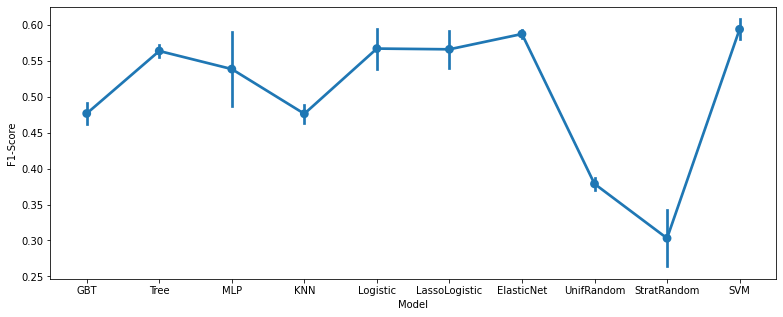

In [30]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.pointplot(x="Model", y="F1-Score", data=df_outer_results, ax=ax)

<AxesSubplot:xlabel='Model', ylabel='value'>

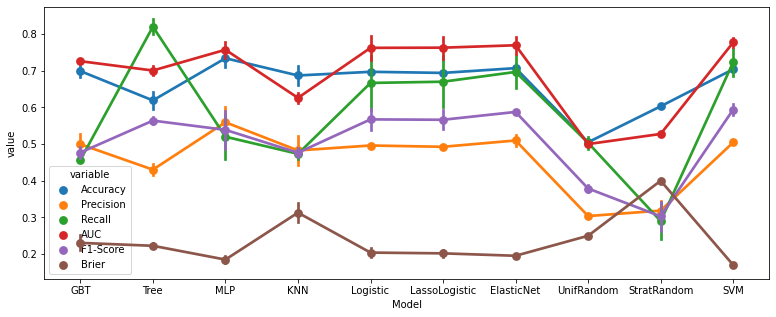

In [31]:
df_melt = df_outer_results.melt(id_vars=["Model"], value_vars=list(perf_metrics.keys()))
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.pointplot(x="Model", y="value", hue="variable", data=df_melt, ax=ax)

In [32]:
df_outer_results.pivot_table(index=["Model"], aggfunc="mean")

,AUC,Accuracy,Brier,F1-Score,Precision,Recall
Model,,,,,,
ElasticNet,0.769352,0.707,0.195486,0.587593,0.509800,0.696667
GBT,0.725962,0.699,0.230611,0.476844,0.499470,0.456667
KNN,0.625952,0.687,0.313000,0.476427,0.482576,0.473333
LassoLogistic,0.762800,0.694,0.202063,0.566270,0.492568,0.670000
Logistic,0.762333,0.697,0.204153,0.567284,0.496101,0.666667
MLP,0.757124,0.734,0.185065,0.538732,0.559398,0.520000
SVM,0.777243,0.704,0.170262,0.594141,0.504553,0.723333
StratRandom,0.527619,0.603,0.400000,0.303009,0.318639,0.290000
Tree,0.700524,0.619,0.222694,0.563929,0.430285,0.820000


In [33]:
a = df_outer_results.pivot_table(index=["Model"], aggfunc="mean")
a[["Brier"]] = 1 - a[["Brier"]]
a.rank()

,AUC,Accuracy,Brier,F1-Score,Precision,Recall
Model,,,,,,
ElasticNet,9.0,9.0,8.0,9.0,9.0,8.0
GBT,5.0,7.0,4.0,4.0,7.0,2.0
KNN,3.0,4.0,2.0,3.0,4.0,3.0
LassoLogistic,8.0,5.0,7.0,7.0,5.0,7.0
Logistic,7.0,6.0,6.0,8.0,6.0,6.0
MLP,6.0,10.0,9.0,5.0,10.0,5.0
SVM,10.0,8.0,10.0,10.0,8.0,9.0
StratRandom,2.0,2.0,1.0,1.0,2.0,1.0
Tree,4.0,3.0,5.0,6.0,3.0,10.0


In [34]:
a.rank().mean(axis=1)

Model
ElasticNet       8.666667
GBT              4.833333
KNN              3.166667
LassoLogistic    6.500000
Logistic         6.500000
MLP              7.500000
SVM              9.166667
StratRandom      1.500000
Tree             5.166667
UnifRandom       2.000000
dtype: float64

# Other Topics

## Scalable models

### Create dataset with different sizes

In [35]:
# small
df_model_small = df_model.copy()

# medium
for k in range(10):
    if k==0:
        df_model_medium = df_model.copy()
    else:
        df_model_medium = pd.concat([df_model_medium, df_model.copy()], axis=0, ignore_index=True)
        
# large
for k in range(100):
    if k==0:
        df_model_large = df_model.copy()
    else:
        df_model_large = pd.concat([df_model_large, df_model.copy()], axis=0, ignore_index=True)

### GBT

In [36]:
from time import time
from sklearn.ensemble import GradientBoostingClassifier
# small
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_small.drop(output_variable, axis=1), 
                                                 df_model_small[output_variable])
print(time() - start)

# medium
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_medium.drop(output_variable, axis=1), 
                                                 df_model_medium[output_variable])
print(time() - start)

# large
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_large.drop(output_variable, axis=1), 
                                                 df_model_large[output_variable])
print(time() - start)

C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.2331845760345459


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


1.4318747520446777


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


18.795020818710327


### LightGBM - https://lightgbm.readthedocs.io/en/latest/index.html

In [37]:
from lightgbm import LGBMClassifier
from time import time
from sklearn.ensemble import GradientBoostingClassifier
# small
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_small.drop(output_variable, axis=1).values, 
                                                 df_model_small[output_variable].values)
print(time() - start)

# medium
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_medium.drop(output_variable, axis=1).values, 
                                                 df_model_medium[output_variable].values)
print(time() - start)

# large
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_large.drop(output_variable, axis=1).values, 
                                                 df_model_large[output_variable].values)
print(time() - start)

0.06582069396972656


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.1560969352722168


C:\Users\askos\.conda\envs\mli\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5455412864685059


### (SGDClassifier, Linear SVM) + Feature Mapping - almost a kernel approach

#### Nystroem

In [38]:
from sklearn.kernel_approximation import Nystroem
nyst = Nystroem(gamma=0.001, n_components=2)
nyst.fit_transform(X)

array([[ 0.34539129, -0.03511583],
       [ 0.61450211,  0.77127858],
       [ 0.49503872, -0.01690374],
       ...,
       [ 0.48149782, -0.00690328],
       [ 0.68037469,  0.70733972],
       [ 0.69263742,  0.69829987]])

explained variance ratio (first two components): [0.9316043 0.0091663]


Text(0.5, 1.0, 'PCA of German Credit dataset')

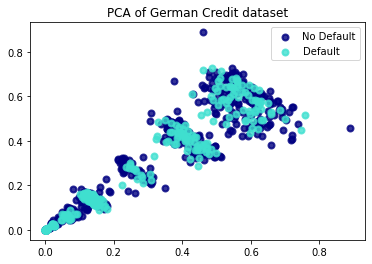

In [39]:
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
nyst = Nystroem(gamma=.01, n_components=2)
X_r = nyst.fit_transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise']
target_names = ["No Default", "Default"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[(y == i).ravel(), 0], X_r[(y == i).ravel(), 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of German Credit dataset')

#### Initial params

In [40]:
#### from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from lightgbm import LGBMClassifier

# k-fold params
inner_folds = StratifiedKFold(n_splits=3, random_state=10) # inner k-fold
outer_folds = StratifiedKFold(n_splits=5, random_state=10) # outer k-fold

# models
model_dict = {"LightGBM": LGBMClassifier(random_state=10),
              "SGD": Pipeline([("std", StandardScaler()),
                               ("map", Nystroem(random_state=10)),
                               ("sgd", SGDClassifier(random_state=10))]),
              "LinearSVM": Pipeline([("std", StandardScaler()),
                                     ("map", Nystroem(random_state=10)),
                                     ("sgd", LinearSVC(dual=False, random_state=10))])
             }

# models hyperparams
hyper_params = {"LightGBM": {"learning_rate": [10.0 ** -1, 10.0 ** 0, 2.0],
                             "max_depth": [1, 2, 3],
                             #"max_features": [0.1, 0.25, 0.5],
                             "n_estimators": [200]},
                "SGD": {"sgd__loss": ["hinge", "log"],
                        "sgd__alpha": [0.01, 0.1, 1.0, 10.0],
                        "sgd__class_weight": [None, "balanced"],
                        "sgd__eta0": [0.001, 0.01, 0.1],
                        "sgd__max_iter": [100],
                        "map__gamma": [0.0001, 0.001, 0.01, 0.1]},
                "LinearSVM": {"sgd__C": [0.01, 0.1, 1.0, 10.0],
                              "sgd__class_weight": [None, "balanced"],
                              "map__gamma": [0.0001, 0.001, 0.01, 0.1]}
               }

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
               # "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
               # "Brier": metrics.brier_score_loss
               }
scorer_metrics = {}
for pf in perf_metrics:
    scorer_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

#### Fit models

In [ ]:
# pre-allocation
X, y = df_model_medium.drop(labels=output_variable, axis=1).values, df_model_medium[output_variable].values
k, z, innercv_results, inner_best_model = 0, 0, {}, {}
df_outer_results = pd.DataFrame(index=[0], columns=["Model", "Time"] + list(perf_metrics.keys()))

# outer loop
for (out_train, out_test) in outer_folds.split(X, y):
    # separation: train, test
    Xtrain, Xtest = X[out_train], X[out_test]
    ytrain, ytest = y[out_train], y[out_test]
    
    # inner loop -- all models
    innercv_results["fold_" + str(k)] = {}
    inner_best_model["fold_" + str(k)] = {}
    start, end = [], []
    for class_model in model_dict.keys():
        start.append(time())
        print((k, class_model))
        innercv_results["fold_" + str(k)][class_model] = GridSearchCV(estimator=model_dict[class_model], 
                                                                       param_grid=hyper_params[class_model], 
                                                                       scoring=scorer_metrics, 
                                                                       cv=inner_folds, 
                                                                       refit="F1-Score")
        innercv_results["fold_" + str(k)][class_model].fit(Xtrain, ytrain.ravel())
        inner_best_model["fold_" + str(k)][class_model] = innercv_results["fold_" + str(k)][class_model].best_estimator_
        end.append(time())
    
    # outer loop prediction
    for (v, class_model) in enumerate(model_dict.keys()):
        # prediction
        ypred_class = inner_best_model["fold_" + str(k)][class_model].predict(Xtest)
        df_outer_results.loc[z, "Model"] = class_model
        df_outer_results.loc[z, "Time"] = end[v] - start[v]
    
        # compute performance metrics
        for pf in perf_metrics.keys():
            df_outer_results.loc[z, pf] = perf_metrics[pf](ytest, ypred_class)
        z += 1
    
    # iteration
    k += 1

# final organisation
df_outer_results[list(perf_metrics.keys()) + ["Time"]] = df_outer_results[list(perf_metrics.keys()) + ["Time"]].astype(float)

#### Show results

In [ ]:
df_outer_results.pivot_table(index=["Model"], aggfunc="mean")

### Deep Gaussian Processes

#### https://gpytorch.ai/

## Other Hyperparameter optimizers

### Bayesian Optimization

#### https://scikit-optimize.github.io/#skopt.gp_minimize

### Tree of Parzen Estimators

#### https://github.com/hyperopt/hyperopt

### Evolutionary Strategies

#### https://deap.readthedocs.io/en/master/

## Explainable Models

### Explainable Boosting Machines

#### https://github.com/microsoft/interpret

### SHAP

#### https://github.com/slundberg/shap

### LIME

#### https://github.com/marcotcr/lime

### Captum

#### https://github.com/pytorch/captum?fbclid=IwAR0P_CvwX-dkUztoUBrcfFDygGGIHRt775pwik86npEUiKuUKudtx55kRDw

## Dealing with time series

### Cross-validation schemes

#### https://github.com/askoshiyama/tsdata-mvapi

### Scikit-learn for time series

#### https://github.com/alan-turing-institute/sktime

### Amazon GluonTS

#### https://github.com/awslabs/gluon-ts